In [ ]:
import torch
from matplotlib import pyplot as plot
from torch.nn import functional as F

In [2]:
with open("names.txt", "r") as f:
    names = [_.strip() for _ in f.readlines()]

names[0:5], len(names)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [3]:
chars = list(set("".join(names)))
chars.insert(0, ".")
chars

['.',
 'c',
 'd',
 's',
 'n',
 'e',
 'i',
 'h',
 'k',
 'j',
 'v',
 'q',
 'r',
 'f',
 'l',
 't',
 'o',
 'u',
 'x',
 'z',
 'g',
 'm',
 'a',
 'p',
 'y',
 'w',
 'b']

In [4]:
ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}

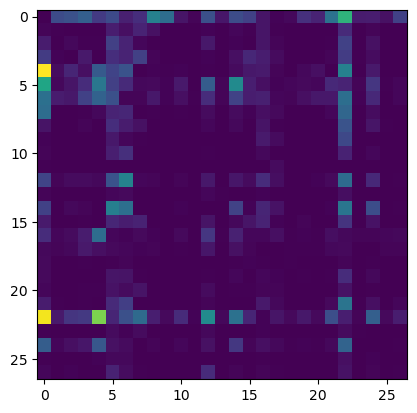

In [5]:
N = torch.zeros((27, 27), dtype=torch.int) # N is count vector

for x in names:
    x = "." + x + "."
    for c1, c2 in zip(x, x[1:]):
        c1i = ctoi[c1]
        c2i = ctoi[c2]
        N[c1i, c2i] += 1
        
plot.imshow(N)

In [10]:
P = N / N.sum(dim=1, keepdims=True)
P[5,:].sum()

tensor(1.0000)

In [13]:
bigrams = []
for x in names:
    x = "." + x + "."
    for c1, c2 in zip(x, x[1:]):
        bigrams.append((c1, c2))

In [12]:
logp = 0;
for c1, c2 in bigrams:
    c1 = ctoi[c1]
    c2 = ctoi[c2]
    logp += P[c1, c2].log().item()

nll = -logp / len(bigrams)
nll

2.454014497322693

In [16]:
gen = torch.Generator()
gen.manual_seed(2147483647)

for _ in range(10):
    sample = "."
    while(True):
        c1 = sample[-1]
        i1 = ctoi[c1]
        i2 = torch.multinomial(P[i1], 1, generator=gen).item()
        sample += itoc[i2]

        if i2 == 0:
            break
    
    print(sample)

.seyde.
.jemormiyarena.
.wilearrish.
.lanavinial.
.k.
.an.
.toreyaimevadashatiay.
.jabien.
.lamaliouen.
.halanani.


## Bigram Neural Net

In [17]:
def create_bigram_ds(names): 
    x = []
    y = []
    for s in names:
        s = "." + s + "."
        for c1, c2 in zip(s, s[1:]):
            x.append(ctoi[c1])
            y.append(ctoi[c2])
    
    x = F.one_hot(torch.tensor(x), num_classes=27).float()
    y = torch.tensor(y)
    
    return x, y
    
x, y = create_bigram_ds(names)
x.shape

torch.Size([228146, 27])

In [18]:
train, dev, test = torch.utils.data.random_split(names, [0.8, 0.1, 0.1])
len(train), len(dev), len(test)

(25627, 3203, 3203)

In [19]:
train_ds = create_bigram_ds(train)
dev_ds = create_bigram_ds(dev)
test_ds = create_bigram_ds(test)

In [33]:
def cal_loss(W, dataset):
    with torch.no_grad():
        X, ys = dataset
        n = X.shape[0]
        logits = X @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        loss = -probs[torch.arange(n), ys].log().mean().item()
    
    return loss

In [38]:
def fits(W, train_ds, dev_ds, epoch):
    X, ys = train_ds
    n = X.shape[0]
    print_ev = epoch / 10
    
    for i in range(epoch):
        W.grad = None
        
        logits = X @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        loss = -probs[torch.arange(n), ys].log().mean()
        loss.backward()

        if i % print_ev == 0:
            dev_loss = cal_loss(W, dev_ds)
            print(f"train: {loss.item():.4f}  dev: {dev_loss:.4f}")

        W.data -= 10 * W.grad

In [46]:
W = torch.randn(27, 27, requires_grad=True)
fits(W, train_ds, dev_ds, 100)

train: 3.5828  dev: 3.5897
train: 3.1112  dev: 3.1147
train: 2.9130  dev: 2.9162
train: 2.8037  dev: 2.8075
train: 2.7347  dev: 2.7395
train: 2.6871  dev: 2.6928
train: 2.6521  dev: 2.6585
train: 2.6254  dev: 2.6324
train: 2.6045  dev: 2.6118
train: 2.5876  dev: 2.5953


In [48]:
def sample(W):
    res = "."
    while(True):
        c = res[-1]
        x = torch.tensor(ctoi[c])
        x = F.one_hot(x, num_classes=27).reshape(1, 27).float()

        logits = x @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdims=True)
        ix = torch.multinomial(probs, 1, generator=gen).item()
        c2 = itoc[ix]

        res += c2
        if c2 == ".":
            break;

    return res

for _ in range(10):
    print(sample(W))

.a.
.inalelebrfqneli.
.iay.
.g.
.h.
.jqzvdonndzatek.
.kaneruea.
.sfxfyfgrikiavelay.
.arierifgjiavben.
.tfwaty.


# Trigram Neural Net

In [50]:
def create_tri_ds(names): 
    x1 = []
    x2 = []
    y = []
    for s in names:
        s = ".." + s + ".."
        for c1, c2, c3 in zip(s, s[1:], s[2:]):
            x1.append(ctoi[c1])
            x2.append(ctoi[c2])             
            y.append(ctoi[c3])            
                                          
    x1 = F.one_hot(torch.tensor(x1), num_classes=27).float()
    x2 = F.one_hot(torch.tensor(x2), num_classes=27).float()
    x = torch.cat([x1, x2], dim=1) # (num_data, 2 * char_num)
    y = torch.tensor(y)
    return x, y
    
x, y = create_tri_ds(train)
x.shape

torch.Size([208200, 54])

In [51]:
train_tds = create_tri_ds(train)
dev_tds = create_tri_ds(dev)
test_tds = create_tri_ds(test)

In [52]:
W = torch.randn(2 * 27, 27, requires_grad=True)
fits(W, train_tds, dev_tds, 1000)

train: 4.2474  dev: 4.2603
train: 2.1958  dev: 2.2018
train: 2.1216  dev: 2.1293
train: 2.0963  dev: 2.1041
train: 2.0834  dev: 2.0911
train: 2.0757  dev: 2.0831
train: 2.0706  dev: 2.0779
train: 2.0670  dev: 2.0741
train: 2.0643  dev: 2.0713
train: 2.0623  dev: 2.0692


In [56]:
def sample_tri(W):
    # rdn_ix = torch.randint(1, 26, (1, )).item()
    sample = ".."
    while(True):
        c1 = sample[-2]
        c2 = sample[-1]
        x1 = F.one_hot(torch.tensor([ctoi[c1]]), num_classes=27).float()
        x2 = F.one_hot(torch.tensor([ctoi[c2]]), num_classes=27).float()
        x = torch.cat([x1, x2], dim=1)

        logits = x @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdims=True)
        ix = torch.multinomial(probs, 1, generator=gen).item()
        c3 = itoc[ix]

        sample += c3
        if c3 == ".":
            break;
            
    return sample

for _ in range(10):
    print(sample_tri(W))

..olya.
..wy.
..al.
..jeyltzira.
..fe.
..onashiy.
..jederanina.
..bel.
..meronaibeagomeidalialy.
..kaqah.
